In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last" # all | last | last_expr | none 

In [3]:
# for name in dir():
#     if not name.startswith('_'):
#         del globals()[name]

In [4]:
# ============= Import required packaages ==============
import time

# Import all custom variables and modules
from custom_classes_defs.preprocessing import *
from custom_classes_defs.Unet_like import *  
# from custom_classes_defs.unet import *  
# from custom_classes_defs.fnet_like import *
# from custom_classes_defs.fnet import *

RND_STATE = 247
BATCH_SIZE = 512
keras.utils.set_random_seed(RND_STATE)
from keras.utils import plot_model

INTERACTIVE_SESSION = True

# -------------------------------------------------------

2024-05-13 21:49:31.348253: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-13 21:49:31.348682: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-13 21:49:31.443400: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-13 21:49:31.622611: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# Verify tensorflow/keras versions
print(f"tensorflow version: {tf.__version__}")
print(f"keras version: {keras.__version__}")

# Verify CPU/GPU availability
print(tf.config.list_physical_devices())
NUM_GPU = len(tf.config.list_physical_devices('GPU'))
print(f"Number of GPUs assigned for computation: {NUM_GPU}")

if NUM_GPU:
    # print GPU info
    !nvidia-smi

tensorflow version: 2.15.0
keras version: 2.15.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Number of GPUs assigned for computation: 1
/usr/local/bin/bash: /opt/miniconda3-py311/lib/libtinfo.so.6: no version information available (required by /usr/local/bin/bash)


Mon May 13 21:49:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:01:00.0 Off |                    0 |
| N/A   27C    P0              58W / 400W |   1404MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

|   1  NVIDIA A100-SXM4-40GB          Off | 00000000:41:00.0 Off |                    0 |
| N/A   26C    P0              50W / 400W |      4MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+----------------------+
|   2  NVIDIA A100-SXM4-40GB          Off | 00000000:81:00.0 Off |                    0 |
| N/A   25C    P0              51W / 400W |      0MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+----------------------+
|   3  NVIDIA A100-SXM4-40GB          Off | 00000000:C1:00.0 Off |                    0 |
| N/A   26C    P0              62W / 400W |   2298MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+---------

### Data preparation and model configurations

In [6]:
print("{}\n\t{}\n{}".format('='*55,'Data preparation and model configurations', '-'*55))
# Images and annations for Thebe seismic data
start = time.time()
img_url = '../data_thebe/seis'
target_url = '../data_thebe/fault'
seis = Thebe(img_url, target_url)
    
# Create datasets for respective data samples and labels
train_dataset = seis.data_generator('train', batch_size=BATCH_SIZE, cache=NUM_GPU) 
val_dataset = seis.data_generator('val', batch_size=BATCH_SIZE, cache=NUM_GPU) 
x_test, y_test = seis.data_generator('test', as_numpy=True)
        
print("Train Dataset:", train_dataset)

print("Size of training data: {}".format(seis.train_size))
print("Size of validation data: {}".format(seis.validation_size))
print("Size of test data: {}".format(seis.test_size)) 

print('...elapsed time: ___{:5.2f} minutes___'.format((time.time()-start) / 60))

	Data preparation and model configurations
-------------------------------------------------------


2024-05-13 21:50:23.700987: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38379 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0


Train Dataset: <CacheDataset element_spec=(TensorSpec(shape=(None, 96, 96), dtype=tf.float32, name=None), TensorSpec(shape=(None, 96, 96), dtype=tf.uint8, name=None))>
Size of training data: 181029
Size of validation data: 64317
Size of test data: 66077
...elapsed time: ___ 0.82 minutes___


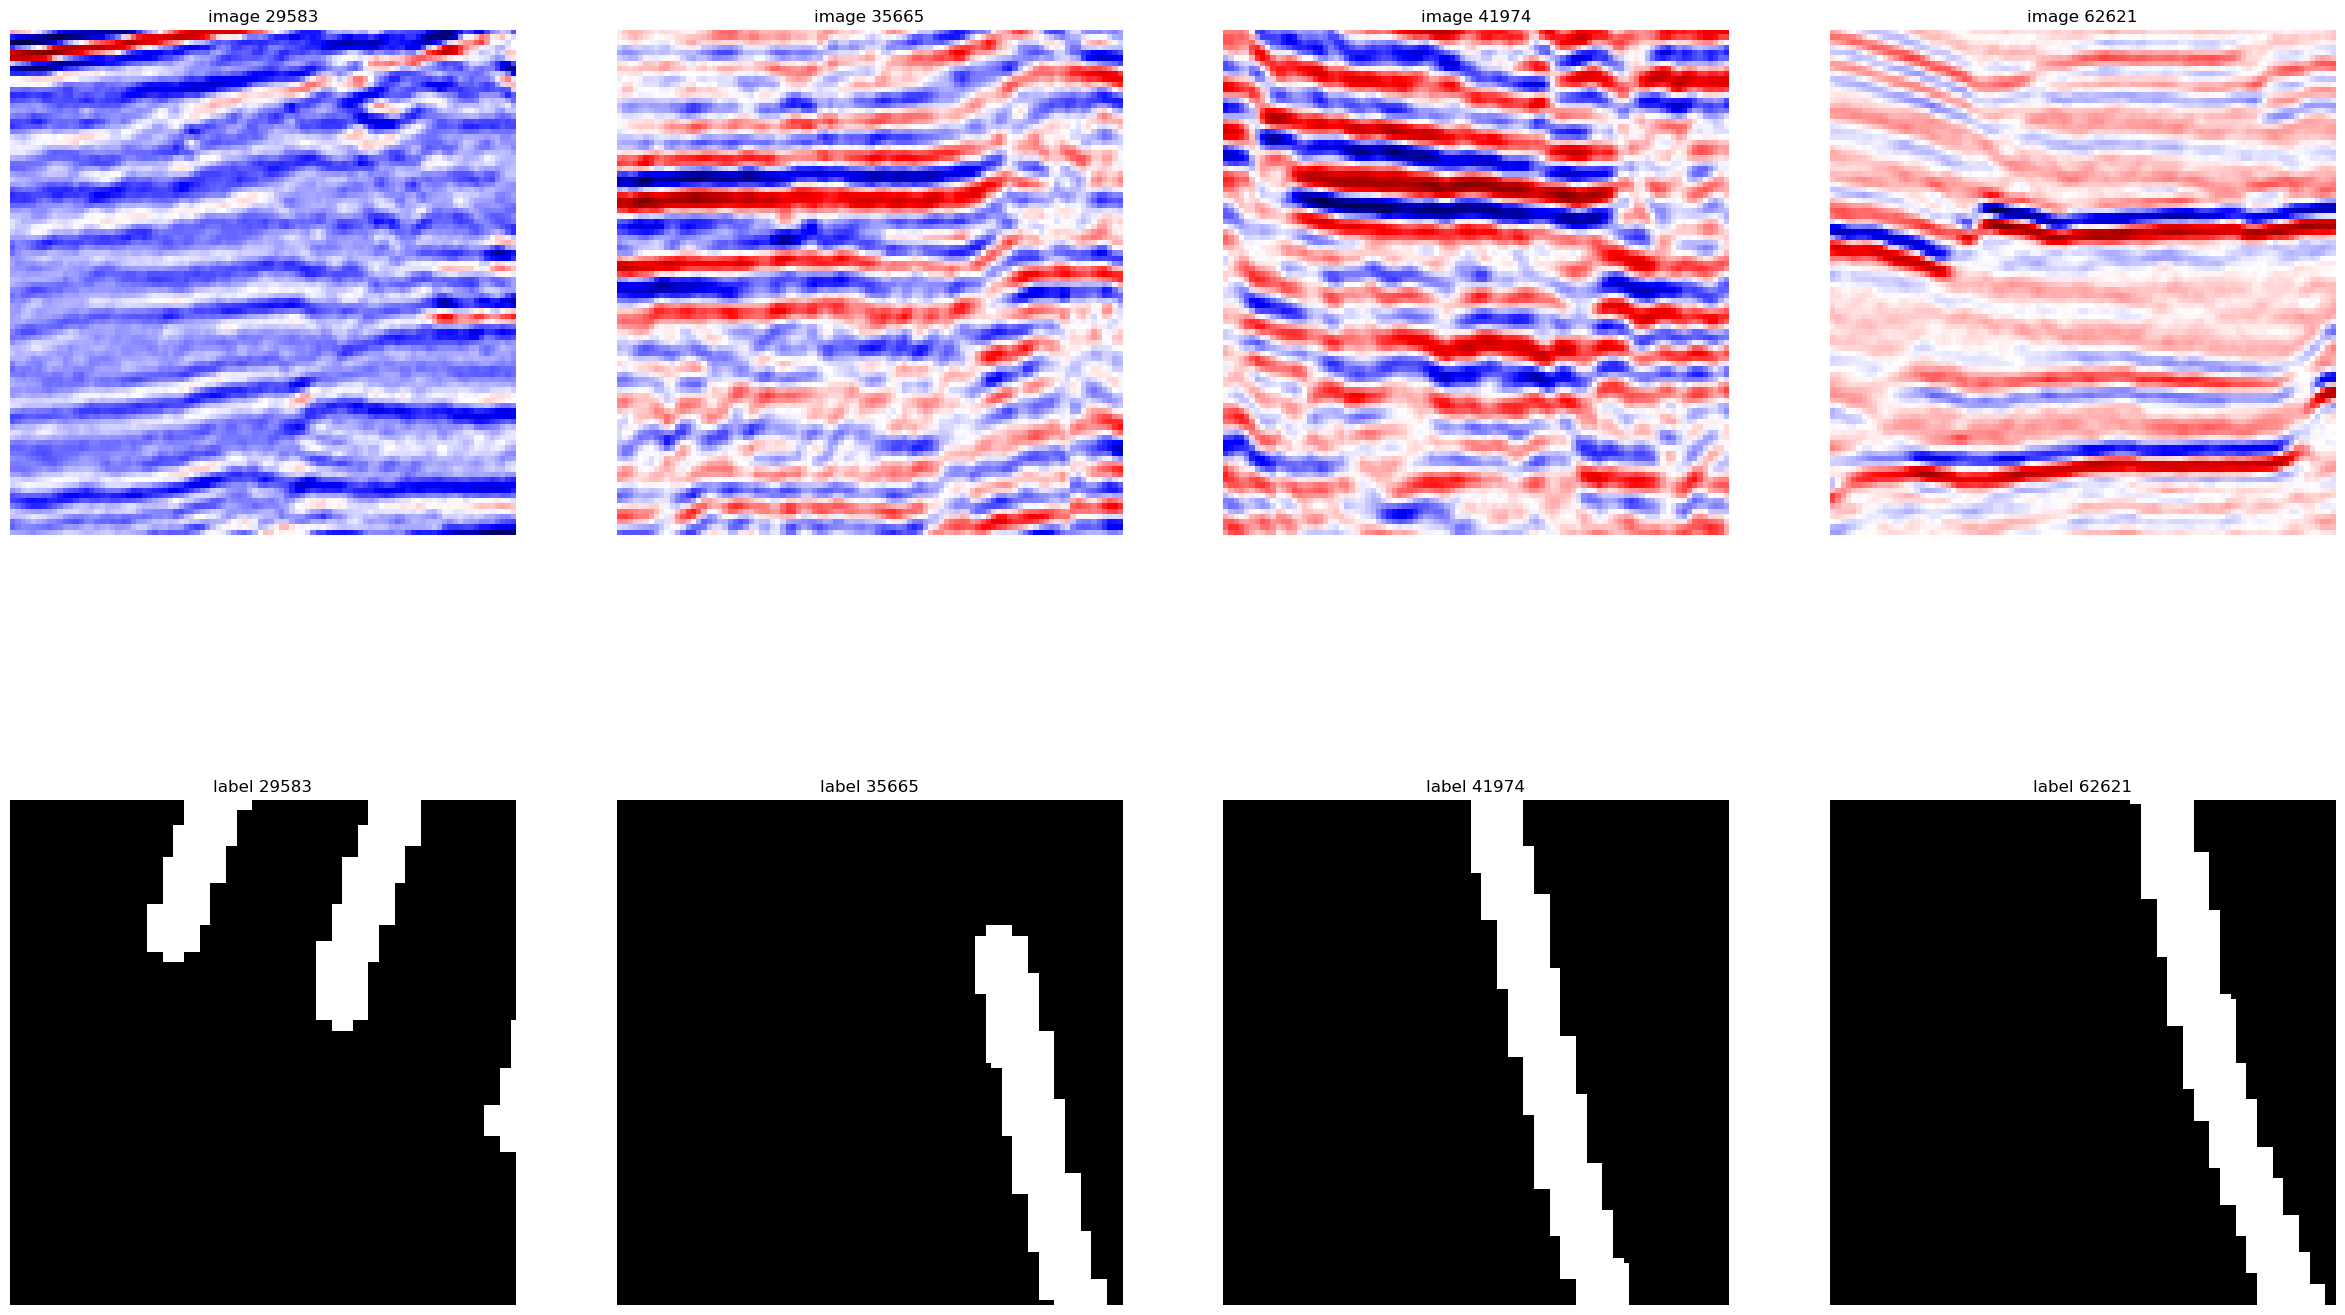

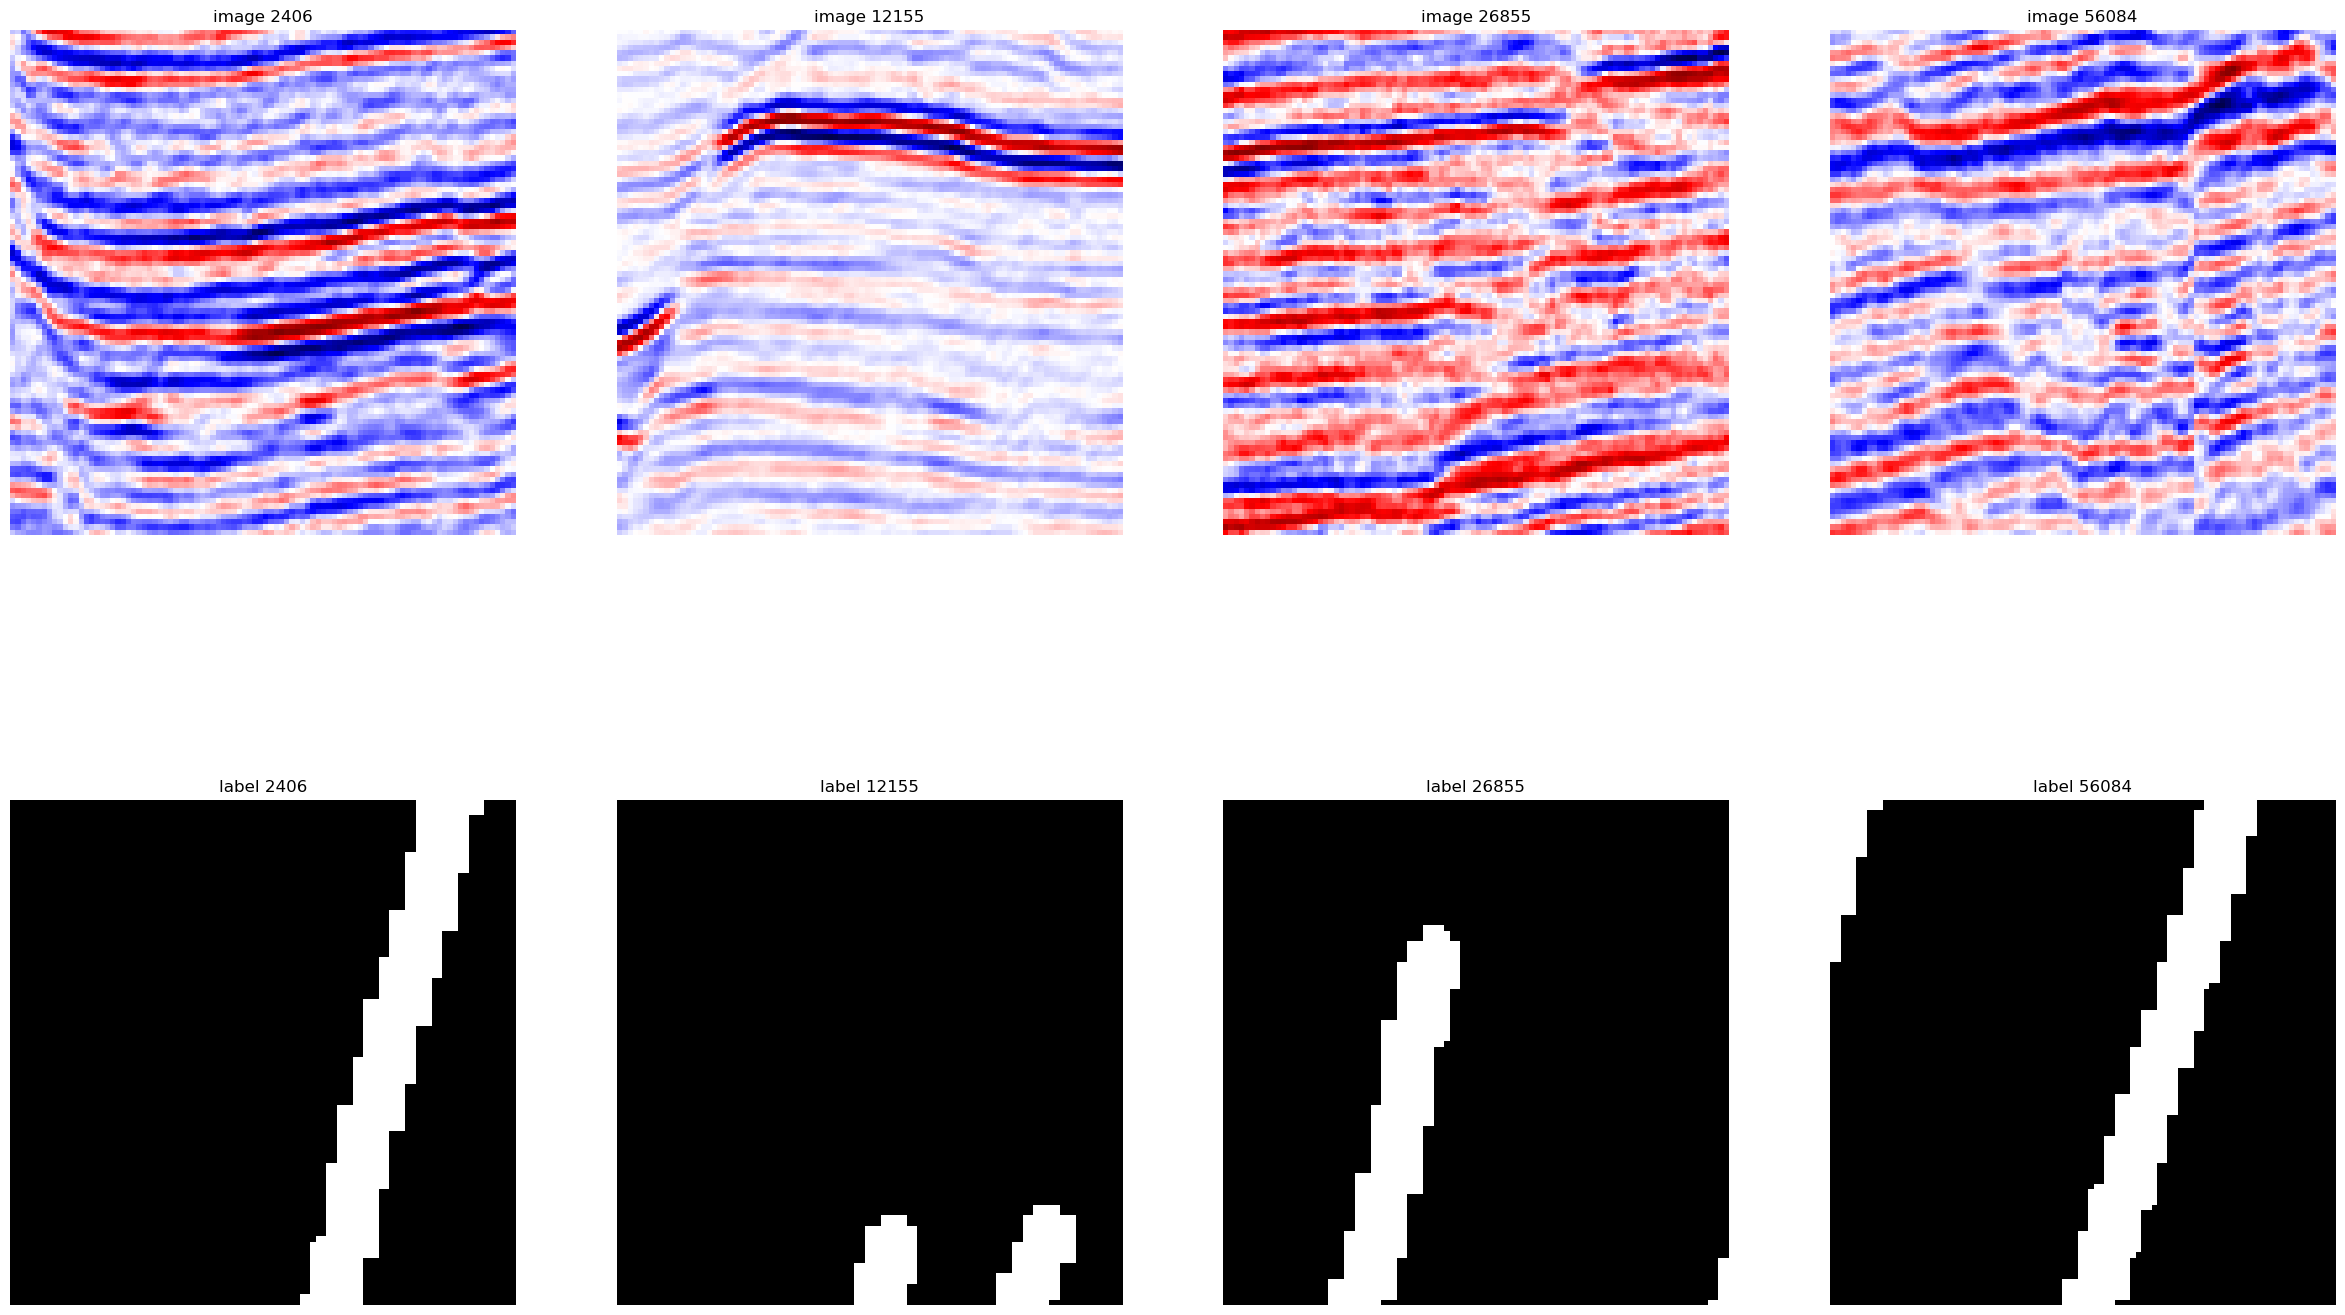

In [7]:
# X, y = next(train_dataset.as_numpy_iterator())
# seis.display_sample_images(X, y)

# X, y = next(val_dataset.as_numpy_iterator())
# seis.display_sample_images(X, y)

seis.display_sample_images(x_test, y_test, num_images=4)
seis.display_sample_images(x_test, y_test, num_images=4)

In [8]:

# Model configurations
conf = model_config(
    epochs=100,
    batch_size=BATCH_SIZE,
    shuffle=True,
    scaling=1,
    save_path='./Thebe/unet-like',
    img_shape=seis.img_size,
    target_size=seis.img_size,
    threshold=seis.threshold,
    pos_label=seis.pos_label,
    train_size=seis.train_size,
    test_size=seis.test_size,
    new_training_session=True,
    multiple_gpu_device=(NUM_GPU>1),
    validation_size=seis.validation_size
)

callbacks = conf.callbacks(
    chkpt_monitor='val_f1_score', 
    es_monitor='val_loss',
    es_patience=15, 
    lr_monitor='val_loss',
    lr_patience=5,
)

conf.set( validation_data=val_dataset,  callbacks=callbacks )
m1 = f1_score(positive_label=seis.pos_label, threshold=seis.threshold)
conf.set(
    'compile',
    metrics= ['accuracy', m1]
)

# conf.double_check(INTERACTIVE_SESSION)
conf.info()

             NUM_GPU: 1
        augmentation: False
        channels_dim: (1, 1)
        compile_args:
                     optimizer: adam
                          loss: binary_crossentropy
                       metrics: accuracy
                              : f1_score(name=f1_score,dtype=float32)
           img_shape: (96, 96)
              labels: ListWrapper([0, 1])
     mixed_precision: None
          model_arch:
                     img_shape: (96, 96)
                   target_size: (96, 96)
                  channels_dim: (1, 1)
                       scaling: 1
                  augmentation: False
 multiple_gpu_device: False
new_training_session: True
           pos_label: 1
           save_path: ./Thebe/unet-like
             scaling: 1
         target_size: (96, 96)
           test_size: 66077
           threshold: 0.5
          train_size: 181029
       training_args:
                        epochs: 100
                    batch_size: 512
                       shuffle:

### Build  model 

In [9]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Build model', '-'*55))

if conf.multiple_gpu_device:

    strategy = tf.distribute.MirroredStrategy()
    print(f"Number of devices: {strategy.num_replicas_in_sync}")
    with strategy.scope():
        m_obj = UNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
        # m_obj = FNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
        model = m_obj.build_model()
        model.compile(**conf.compile_args)

else:

    m_obj = UNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
    # m_obj = FNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
    model = m_obj.build_model()
    model.compile(**conf.compile_args)


# model.summary()
# keras.utils.plot_model(model, 'm_obj.png',show_shapes=True)
# plot_model(model, 'm_obj.png',show_shapes=True)
num_trainable_weights = sum([np.prod(w.shape) for w in model.trainable_weights])
print(f"Total number of parameters: {model.count_params():,}")
print(f"Total trainable wieghts: {num_trainable_weights:,}")
print(f"Total non-trainable wieghts: {model.count_params()-num_trainable_weights:,}")





	Build model
-------------------------------------------------------


Total number of parameters: 503,809
Total trainable wieghts: 500,033
Total non-trainable wieghts: 3,776


### Train  model

In [10]:
# print("\n\n{}\n\t{}\n{}".format('='*55,f'Train {m_obj.Name} model', '-'*55))

# model, train_history = \
#     conf.execute_training(
#         model, 
#         data=train_dataset, 
#         plot_history=INTERACTIVE_SESSION
# )


In [11]:
# show_convergence(train_history.history, ['accuracy','val_accuracy'])

In [12]:
# show_convergence(train_history.history, ['f1_score','val_f1_score'])

### Evaluate and Vizualize

In [13]:
# print("\n\n{}\n\t{}\n{}".format('='*55,f'Evaluate {m_obj.Name} model', '-'*55))
# decoded_imgs = model.predict(x_test)


In [14]:

# if INTERACTIVE_SESSION:
#     display_sample_images(x_test, decoded_imgs, conf.img_shape)
    

In [15]:
# model.evaluate(x=x_test)


In [16]:

# scores = conf.evaluate_sklearn(y_test, decoded_imgs,report=True)
# print(scores)